## ARIMA

Imports and Data Collection

In [50]:
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
%matplotlib inline
pd.set_option('display.max_columns', 500)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import yfinance as yf

Code

In [52]:
class time_series:
  def __init__(self, ticker, start_date, end_date, interval):
    self.ticker = yf.Ticker(ticker)
    self.start_date = start_date
    self.end_date = end_date
    self.interval = interval
    self.data = self.ticker.history(start=self.start_date, end=self.end_date, interval=self.interval)

  def plot_closing_prices(self):
    plt.figure(figsize=(20, 10))
    plt.plot(self.data['Close'], lw=1.5, label='Close Price of {}'.format(self.ticker), color='red')
    plt.xlabel('Dates')
    plt.ylabel('Price ($)')
    plt.title('Close prices for MSFT')
    plt.grid(True);
    plt.show()

  def plot_volume(self):
    plt.figure(figsize=(20, 10))
    plt.plot(self.data['Volume'], lw=1.5, label='Volume of {}'.format(self.data), color='blue')
    plt.xlabel('Dates')
    plt.ylabel('Price ($)')
    plt.title('Volume for MSFT')
    plt.grid(True);
    plt.show()

  def ADF(self):
    result = adfuller(self.data['Close'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t{}: {}'.format(key, value))

  def differencing(self, diff_num):
    self.data["diff_{}".format(diff_num)] = self.data["Close"].diff(periods=diff_num)
    result = adfuller(self.data.iloc[1:, :][['diff_{}'.format(diff_num)]])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
      print('\t{}: {}'.format(key, value))

  def plot_diff_data(self):
    plt.figure(figsize=(20, 10))
    plt.plot(self.data['diff_1'], lw=1.5, label='Close Price of {} (differencing)'.format(self.ticker), color='red')
    plt.xlabel('Dates')
    plt.ylabel('Price ($)')
    plt.title('Close prices for MSFT')
    plt.grid(True)
    plt.show()

  def preprocessing(self):
    self.training = self.data.iloc[1:len(self.data)-365, :]
    self.testing = self.data.iloc[len(self.data)-365-1:, :]

  def ARIMA_model(self, p, d, q):
    model = ARIMA(self.training['Close'], order=(p,d,q))
    model_fit = model.fit()
    return model_fit

  def ARIMA_fit(self, p, d, q):
    historical = list(self.training['Close'])
    self.pred = []

    for i in range(len(self.testing['Close'])):
      model = ARIMA(historical, order=(1,1,1)).fit()
      y_pred = model.forecast()
      self.pred.append(y_pred)
      obs = self.testing['Close'][i]
      historical.append(obs)
      #print('predicted=%f, expected=%f' % (y_pred, obs))

  def plot_ARIMA_predicted_observed(self):
    plt.figure(figsize=(20, 10))
    plt.plot(list(self.testing['Close']), label='Observed')
    plt.plot(self.pred, label='Predicted')
    plt.xlabel('Dates')
    plt.ylabel('Price ($)')
    plt.title('Predicted vs. Observed Prices')
    plt.grid(True)
    plt.show()

  def ARIMA_eval(self):
    rmse = math.sqrt(mean_squared_error(self.testing['Close'], self.pred))
    print('Test RMSE: %.3f' % rmse)
    r2 = r2_score(self.testing['Close'], self.pred)
    print('Test r^2: %.3f' % r2)

In [53]:
MSFT = time_series('MSFT', '2005-12-01', '2022-10-03', '1d')

Let's take a look at a plot of closing prices over the years.

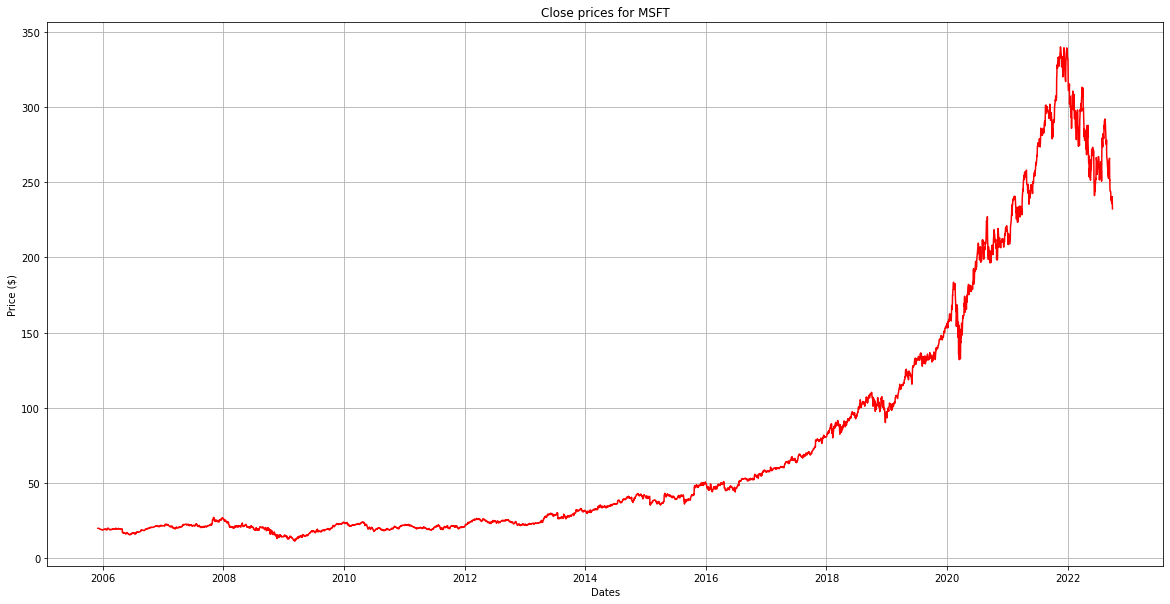

In [54]:
MSFT.plot_closing_prices()

Now let's look at a plot of the stock's volume over the years.

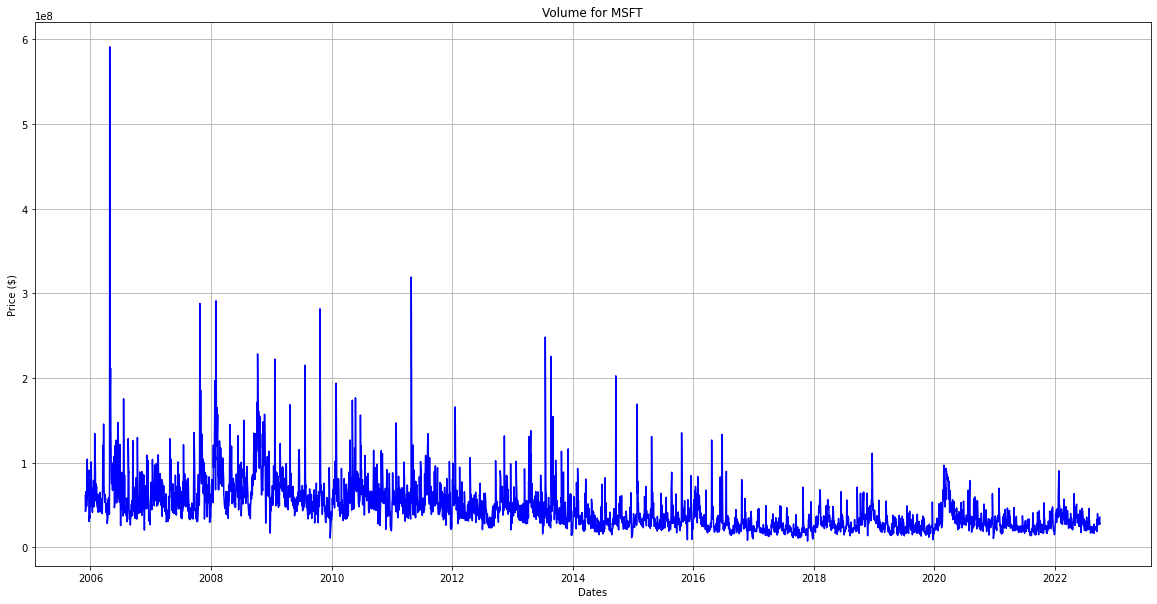

In [55]:
MSFT.plot_volume()

Next, let's check if the data is stationary, meaning mean and variance do not vary across time.  We can check this using the Augmented Dickey-Fuller Test. In this test, when the p-value is low, the data is stationary.

In [56]:
MSFT.ADF()

ADF Statistic: 0.8667283117368649
p-value: 0.9926403912489938
Critical Values:
	1%: -3.4319060752453483
	5%: -2.862227588385493
	10%: -2.567136009040254


Our p-value is very high, thus our data is non-stationary, meaning we cannot use it for modeling unless we transform it to make it stationary. One way to do this is through differencing and check the updated Augmented Dickey-Fuller Test.

In [57]:
MSFT.differencing(1)

ADF Statistic: -12.752884983593235
p-value: 8.459936519276906e-24
Critical Values:
	1%: -3.4319064456133153
	5%: -2.862227751998474
	10%: -2.567136096140145


Now our p-value is very low, so we have enough evidence to reject the null hypothesis and conclude that the data is stationary after just differencing by one period.

Let's see what this data looks like.

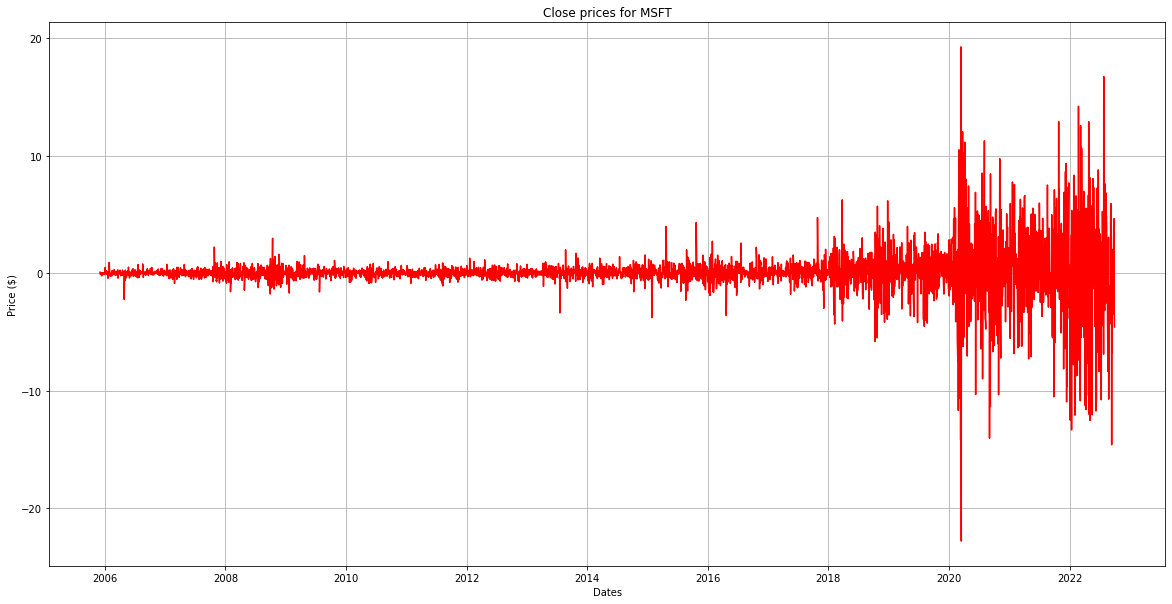

In [58]:
MSFT.plot_diff_data()

Let's preprocess the data so we can create models that will predict the closing prices from the last year. 

In [59]:
MSFT.preprocessing()

Now, let's create our ARIMA model.

Let's understand the ARIMA model (AutoRegressive Integrated Moving Average) by breaking up its name:

- AR (AutoRegression) - predicts future values based on previous values
- I (Integrated) - uses differencing to make the data stationary
- MA (Moving Average) - represents dependency between an observation and its residual error from a moving average model

Parameters:
- p: number of autoregressive terms in the model
- d: number of times observations are differenced
- q: size of moving average window

In [60]:
%%time
MSFT.ARIMA_model(1, 1, 1)
MSFT.ARIMA_fit(1, 1, 1)

In [61]:
MSFT.ARIMA_model(1, 1, 1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3871
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6867.967
Date:                Wed, 11 Jan 2023   AIC                          13741.934
Time:                        06:05:25   BIC                          13760.717
Sample:                             0   HQIC                         13748.603
                               - 3871                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2879      0.016    -17.557      0.000      -0.320      -0.256
ma.L1          0.0400      0.017      2.284      0.022       0.006       0.074
sigma2         2.0369      0.012    171.682      0.000       2.014       2.060
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            163569.53
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              41.42   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From looking at this table, one thing I would like to note is that the estimates are all statistically significant (all with p-values less than .05).

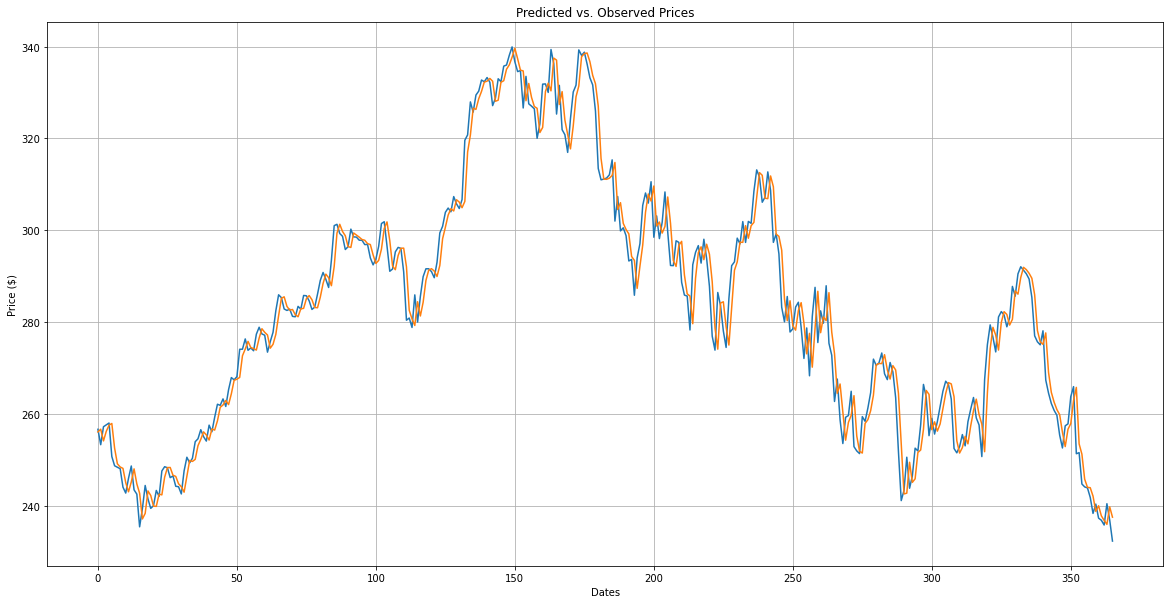

In [62]:
MSFT.plot_ARIMA_predicted_observed()

Now let's evaluate the ARIMA model based on it's r^2 and RMSE.

In [63]:
MSFT.ARIMA_eval()

Test RMSE: 4.934
Test r^2: 0.966


Updates coming soon: Attempt at other algos to predict longer term stock price trends, evaluating ARIMA for higher frequency data